# Who feeds the world ? And how wealthy are they ?
There are folium maps in this notebook. If they do not display well, please have a look at the .html file from the same repo.

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)  
                
    3. [Structure of international trade](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    2. [Food self-sufficiency](#3B)

    3. [Giving countries an economic score based on their agricultural features](#3C)

    4. [Food prices stability and agricultural features](#3D)      

4. [Informed plan for next actions](#4)

**External imports:**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
import json
import re
import requests
from bs4 import BeautifulSoup
from ipywidgets import interact
from IPython.display import display

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [2]:
#from Milestone_2_scripts import *

**Setup:**

In [3]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Crops trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Consumer price indices" : "ConsumerPriceIndices_E_All_Data_(Normalized).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the "Macroeconomy" dataset](#1Dai)
            
            2. [Extracting crops harvested area, production, seed and yield from the "Crops production" dataset](#1Daii)
            
            3. [Extracting stocks production from the "Livestock production" dataset](#1Daiii)
            
            4. [Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets](#1Daiv)
            5. [Extracting average CPI of each year from the "Consumer price indices" dataset](#1Dav)
            
            6. [Removing areas which are not countries](#1Davi)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)        
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [4]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [5]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets in order to get a first sense of the data.

In [6]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [7]:
display_df(df, interesting_datasets)

'Crops production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
1426400,183,Romania,1726,"Pulses,Total",5312,Area harvested,1976,1976,ha,837800.0,A
572925,60,El Salvador,600,Papayas,5510,Production,1981,1981,tonnes,2200.0,F
1171963,148,Nauru,249,Coconuts,5419,Yield,1982,1982,hg/ha,50000.0,Fc
900301,109,Jamaica,137,Yams,5510,Production,1980,1980,tonnes,132893.0,NaN
1542124,202,South Africa,1729,"Treenuts,Total",5312,Area harvested,1995,1995,ha,1917.0,A


'Crops trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
9720335,207,Suriname,165,Molasses,5622,Import Value,1969,1969,1000 US$,0.0,NaN
14491087,5817,Net Food Importing Developing Countries,1187,"Cocoons, unreelable & waste",5610,Import Quantity,1975,1975,tonnes,0.0,A
5364400,106,Italy,449,Mushrooms and truffles,5910,Export Quantity,1976,1976,tonnes,817.0,NaN
7925437,168,Papua New Guinea,162,Sugar Raw Centrifugal,5622,Import Value,1965,1965,1000 US$,0.0,NaN
12069670,5102,Middle Africa,892,"Yoghurt, concentrated or not",5910,Export Quantity,1986,1986,tonnes,NaN,A


'Consumer price indices'

,Area Code,Area,Item Code,Item,Months Code,Months,Year Code,Year,Unit,Value,Flag,Note
21929,90,Guinea,23013,"Consumer Prices, Food Indices (2010 = 100)",7003,March,2012,2012,NaN,826.089740,X,2002
55840,222,Tunisia,23012,"Consumer Prices, General Indices (2010 = 100)",7008,August,2008,2008,NaN,92.748482,X,2010
51938,207,Suriname,23012,"Consumer Prices, General Indices (2010 = 100)",7012,December,2005,2005,NaN,75.282231,X,2010
15220,72,Djibouti,23012,"Consumer Prices, General Indices (2010 = 100)",7010,October,2010,2010,NaN,101.340483,X,2010
55910,222,Tunisia,23012,"Consumer Prices, General Indices (2010 = 100)",7012,December,2009,2009,NaN,98.151306,X,2010


'Macroeconomy'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
78240,29,Burundi,22075,Value Added (Total Manufacturing),6155,Annual growth Local Currency,2014,2014,%,-0.061991,Fc
455010,210,Sweden,22015,Gross Fixed Capital Formation,6129,Annual growth US$,1985,1985,%,9.530968,Fc
140291,54,Denmark,22075,Value Added (Total Manufacturing),6117,"Share of GDP in US$, 2005 prices",1972,1972,%,15.604311,Fc
475958,220,Trinidad and Tobago,22015,Gross Fixed Capital Formation,6108,"Value US$, 2005 prices",1973,1973,millions,2257.357094,XAM
463238,208,Tajikistan,22076,"Value Added (Manufacture of food, beverages an...",6109,Value Local Currency,2013,2013,millions,NaN,NaN


'Livestock production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
50559,89,Guatemala,1034,Pigs,5111,Stocks,1973,1973,Head,880600.0,NaN
135590,5104,Southern Africa,1746,Cattle and Buffaloes,5111,Stocks,1975,1975,Head,18248121.0,A
91325,171,Philippines,1096,Horses,5111,Stocks,1980,1980,Head,250000.0,NaN
144683,5303,Southern Asia,2029,Poultry Birds,5112,Stocks,2014,2014,1000 Head,2921131.0,A
64253,118,Kuwait,866,Cattle,5111,Stocks,1966,1966,Head,4400.0,F


'Live animals trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
512201,251,Zambia,1922,Sheep and Goats,5608,Import Quantity,1982,1982,Head,7.0,A
63668,239,British Virgin Islands,1034,Pigs,5922,Export Value,1977,1977,1000 US$,0.0,NaN
150755,58,Ecuador,1057,Chickens,5909,Export Quantity,1986,1986,1000 Head,0.0,NaN
509051,248,Yugoslav SFR,1882,"Agricult.Products,Total",5622,Import Value,1969,1969,1000 US$,306084.0,A
623182,5500,Oceania,946,Buffaloes,5922,Export Value,2007,2007,1000 US$,NaN,A


At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unuseful data  <a name="1Da"></a>

In this section, we will create dataframes in `df_useful` which correspond to previous dataframes without the unuseful data.

In [8]:
df_useful = {}

##### 1.D.a.i. Extracting GDP from the "Macroeconomy" dataset <a name="1Dai"></a>

In [9]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [10]:
df_useful["GDP"] = extract_GDP(df["Macroeconomy"])

In [11]:
display(df_useful["GDP"].sample(5))

,Area Code,Area,Year,Value
433800,201,Somalia,2009,2011.708219
509361,235,Uzbekistan,2015,69004.097805
438821,277,South Sudan,1996,NaN
121564,98,Croatia,2000,21774.361387
454229,210,Sweden,1979,121647.191520


##### 1.D.a.ii. Extracting crops harvested area, production, seed and yield from the "Crops production" dataset<a name="1Daii"></a>

In [12]:
def get_food_crops():
    #Return a list of crops categorized as food crops https://world-crops.com/food-crops/
    url="https://world-crops.com/food-crops/"
    r=requests.get(url,headers={"User-Agent": "XY"})
    soup=BeautifulSoup(r.text,'html.parser')
    elements_temp=soup.find_all('a',href=re.compile("^../"))
    elements=[el.text for el in elements_temp]
    
    #only 40 elements are displayed on each page->iterating on the total list
    for i in range(40,401,40):
        url_i=url+"?ss="+str(i)
        r=requests.get(url_i,headers={"User-Agent":"XY"})
        soup=BeautifulSoup(r.text,'html.parser')
        new_elements=soup.find_all('a',href=re.compile("^../"))
        elements+=[el.text for el in new_elements]
    return elements

def inclusive_search(string,elements):
    #returns true if the string can be found in elements. The search removes special characters from string in order to include more positive results
    string=string.lower()
    delimiters = ",", "(","&",")"," and "," "
    pattern = '|'.join(map(re.escape, delimiters))
    strings=list(filter(None,re.split(pattern,string)))
    found=False
    for s in strings:
        if s=="nes":
            continue
        for el in elements:
            found=(s in el.split())
            if found==False and s[-1]=="s":
                found=s[:-1] in el.split()
            if found==False and s[-2:]=="es":
                found=s[:-2] in el.split()
            if found==False and s[-3:]=="ies":
                found=s[:-3]+"y" in el.split()
            if found==True:
                return found
    return found


def get_food_crop_data(df):    
    #extracts the food crop data, returns 4 df: Area,Production,Seed and yield    
    df=df.copy()
    food_crops=list(map(lambda x: x.lower(),get_food_crops()))              
    crop_types_df=df[['Item','Value']].groupby('Item').sum()
    crop_types_df=crop_types_df[list(map(lambda x : inclusive_search(x,food_crops) , crop_types_df.index ))]   
    food_crop_df=df[df.Item.apply(lambda x: x in crop_types_df.index)]
    return (food_crop_df[food_crop_df.Element=='Area harvested'],
            food_crop_df[food_crop_df.Element=='Production'],
            food_crop_df[food_crop_df.Element=='Seed'],
            food_crop_df[food_crop_df.Element=='Yield'])
  
food_crop_area_df , food_crop_production_df , food_crop_seed_df , food_crop_yield_df = get_food_crop_data(df["Crops production"])

In [13]:
df_useful['Crops Area harvested'] = food_crop_area_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Production'] = food_crop_production_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Seed'] = food_crop_seed_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops Yield'] =  food_crop_yield_df.drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [14]:
display(df_useful['Crops Area harvested'].sample(5))
display(df_useful['Crops Production'].sample(5))
display(df_useful['Crops Seed'].sample(5))
display(df_useful['Crops Yield'].sample(5))

,Area Code,Area,Item,Year,Unit,Value
1707436,223,Turkey,"Fruit, tropical fresh nes",2008,ha,NaN
937929,114,Kenya,"Beans, green",1965,ha,NaN
756489,93,Haiti,Chicory roots,1997,ha,9.0
742502,175,Guinea-Bissau,Papayas,2004,ha,220.0
2157505,5300,Asia,Coconuts,2006,ha,8971245.0


,Area Code,Area,Item,Year,Unit,Value
1195611,153,New Caledonia,"Coffee, green",1975,tonnes,1500.0
2116330,5206,Caribbean,"Onions, shallots, green",1968,tonnes,606.0
1972168,5102,Middle Africa,Oats,1988,tonnes,0.0
1410621,182,Réunion,Cereals (Rice Milled Eqv),1975,tonnes,13214.0
1829730,237,Viet Nam,Bananas,2004,tonnes,1329400.0


,Area Code,Area,Item,Year,Unit,Value
433767,107,Côte d'Ivoire,Fonio,1969,tonnes,93.0
2048971,5200,Americas,Lentils,1971,tonnes,3859.0
1639634,216,Thailand,Castor oil seed,1982,tonnes,133.0
652932,75,Gambia,Sorghum,2000,tonnes,900.0
304736,39,Chad,Potatoes,2004,tonnes,3938.0


,Area Code,Area,Item,Year,Unit,Value
2471670,5801,Least Developed Countries,Buckwheat,2008,hg/ha,9120.0
1743614,225,United Arab Emirates,"Mangoes, mangosteens, guavas",1971,hg/ha,130000.0
815751,101,Indonesia,"Mangoes, mangosteens, guavas",2005,hg/ha,80278.0
54310,9,Argentina,Figs,2006,hg/ha,33462.0
1285602,166,Panama,Carrots and turnips,1992,hg/ha,74978.0


##### 1.D.a.iii. Extracting stocks production from the "Livestock production" dataset<a name="1Daiii"></a>

In [15]:
selection_stocks = df['Livestock production']["Element"] == 'Stocks'

df_useful['Livestock production'] = df['Livestock production'][selection_stocks].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [16]:
display(df_useful['Livestock production'].sample(5))

,Area Code,Area,Item,Year,Unit,Value
6185,11,Austria,Geese and guinea fowls,2009,1000 Head,25.0
131088,5100,Africa,Cattle,1968,Head,142563636.0
149839,5403,Southern Europe,Cattle,1970,Head,21558467.0
102448,195,Senegal,Cattle,1988,Head,2465000.0
75713,145,Micronesia (Federated States of),Cattle,1995,Head,13900.0


##### 1.D.a.iv. Extracting import and export quantities from the "Live animals trade" and "Crops trade" datasets<a name="1Daiv"></a>

In [17]:
selection_import_quantities = df['Live animals trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Live animals trade']["Element"] == 'Export Quantity'

df_useful['Live animals import quantities'] = df['Live animals trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Live animals export quantities'] = df['Live animals trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [18]:
display(df_useful['Live animals import quantities'].sample(5))

,Area Code,Area,Item,Year,Unit,Value
27934,52,Azerbaijan,Sheep,2011,Head,4216.0
641945,5801,Least Developed Countries,Beehives,1980,No,NaN
235452,105,Israel,"Bovine, Animals",1973,Head,1478.0
7660,5,American Samoa,Cattle,1989,Head,0.0
323550,153,New Caledonia,Ducks,1991,1000 Head,NaN


In [19]:
display(df_useful['Live animals export quantities'].sample(5))

,Area Code,Area,Item,Year,Unit,Value
152643,58,Ecuador,"Bovine, Animals",1966,Head,0.0
350527,165,Pakistan,Sheep and Goats,1972,Head,0.0
555683,5200,Americas,Buffaloes,1979,Head,0.0
438581,209,Swaziland,Horses,1989,Head,0.0
319682,150,Netherlands,Horses,1976,Head,16525.0


In [20]:
selection_import_quantities = df['Crops trade']["Element"] == 'Import Quantity'
selection_export_quantities = df['Crops trade']["Element"] == 'Export Quantity'

df_useful['Crops import quantities'] = df['Crops trade'][selection_import_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])
df_useful['Crops export quantities'] = df['Crops trade'][selection_export_quantities].drop(columns=['Item Code', "Element Code", "Element", "Year Code", "Flag"])

In [21]:
display(df_useful['Crops import quantities'].sample(5))

,Area Code,Area,Item,Year,Unit,Value
984516,15,Belgium-Luxembourg,Cassava Equivalent,1974,tonnes,992955.0
3601658,63,Estonia,Plantains,2003,tonnes,NaN
11107967,155,Vanuatu,Chocolate products nes,1971,tonnes,37.0
2799499,107,Côte d'Ivoire,Flax fibre and tow,1983,tonnes,NaN
477800,10,Australia,Tea,1995,tonnes,15300.0


In [22]:
display(df_useful['Crops export quantities'].sample(5))

,Area Code,Area,Item,Year,Unit,Value
12556331,5204,Central America,"Offals, liver duck",2011,tonnes,0.0
5468668,109,Jamaica,Oilseed Cake Meal,1993,tonnes,0.0
2968507,50,Cyprus,Lard,2005,tonnes,0.0
10852304,215,United Republic of Tanzania,"Honey, natural",2010,tonnes,429.0
1519706,26,Brunei Darussalam,Oilseed Cake nes,1981,tonnes,5.0


##### 1.D.a.v. Extracting average CPI of each year from the "Consumer price indices" dataset<a name="1Dav"></a>

In [23]:
df_useful['Consumer price indices'] =  df['Consumer price indices'][['Area',"Year",'Value']] \
                                        .dropna() \
                                        .groupby(['Area',"Year"]) \
                                        .mean() \
                                        .reset_index() \
                                        .dropna()

In [24]:
display(df_useful['Consumer price indices'].sample(5))

,Area,Year,Value
70,Angola,2016,213.196921
91,Antigua and Barbuda,2002,84.199569
3001,Thailand,2005,86.570762
1070,Finland,2004,84.099943
1618,Kosovo,2007,90.551621


##### 1.D.a.vi. Removing areas which are not countries <a name="1Davi"></a>

Having a more detailled look at the dataset, we have remarked that the areas which are real countries are exactely the ones with an "Area Code" below 5000.

In [25]:
#remove Area code >= 5000
for df_name in df_useful :
    if 'Area Code' in df_useful[df_name].keys() : 
        print ("Removing areas which are not countries in", df_name)
        selection_countries = df_useful[df_name]['Area Code']<5000
        df_useful[df_name] = df_useful[df_name][selection_countries]
        display(df_useful[df_name].sample(5))
    else :
        print (df_name, "is already clean")

Removing areas which are not countries in GDP


,Area Code,Area,Year,Value
285858,132,Maldives,1990,278.366109
306166,140,Monaco,2009,5452.402869
371124,171,Philippines,1998,72206.940479
138744,54,Denmark,1999,177964.204210
408308,193,Sao Tome and Principe,1984,74.382097


Removing areas which are not countries in Crops Area harvested


,Area Code,Area,Item,Year,Unit,Value
1830865,237,Viet Nam,Cauliflowers and broccoli,2005,ha,2127.0
1303493,169,Paraguay,Garlic,1984,ha,900.0
934145,108,Kazakhstan,Rye,2002,ha,77420.0
224249,27,Bulgaria,Chestnut,1986,ha,NaN
983012,121,Lebanon,"Groundnuts, with shell",2013,ha,2300.0


Removing areas which are not countries in Crops Production


,Area Code,Area,Item,Year,Unit,Value
23615,4,Algeria,Figs,1964,tonnes,58000.0
416487,47,Cook Islands,Coconuts,1966,tonnes,14000.0
1132642,143,Morocco,Figs,1994,tonnes,65000.0
980435,121,Lebanon,"Beans, green",1963,tonnes,4000.0
713313,87,Guadeloupe,Yams,1999,tonnes,10032.0


Removing areas which are not countries in Crops Seed


,Area Code,Area,Item,Year,Unit,Value
4435,2,Afghanistan,"Rice, paddy",1971,tonnes,22050.0
201078,21,Brazil,"Beans, dry",2003,tonnes,173031.0
1293018,166,Panama,"Roots and Tubers,Total",1998,tonnes,4417.0
1592431,209,Swaziland,"Beans, dry",1974,tonnes,42.0
426044,48,Costa Rica,Potatoes,1994,tonnes,2194.0


Removing areas which are not countries in Crops Yield


,Area Code,Area,Item,Year,Unit,Value
545388,58,Ecuador,Pineapples,1979,hg/ha,171929.0
1705044,223,Turkey,Cherries,1972,hg/ha,54931.0
1819788,236,Venezuela (Bolivarian Republic of),"Fruit, fresh nes",2005,hg/ha,175101.0
893424,109,Jamaica,"Chillies and peppers, green",1965,hg/ha,61077.0
253686,35,Cabo Verde,Cassava,1979,hg/ha,120000.0


Removing areas which are not countries in Livestock production


,Area Code,Area,Item,Year,Unit,Value
123464,234,Uruguay,Goats,1965,Head,17000.0
70391,130,Malawi,Cattle,1993,Head,796728.0
15497,239,British Virgin Islands,Cattle,1968,Head,2900.0
89287,168,Papua New Guinea,Cattle and Buffaloes,1994,Head,93000.0
41512,67,Finland,Beehives,1991,No,49000.0


Removing areas which are not countries in Live animals import quantities


,Area Code,Area,Item,Year,Unit,Value
300221,138,Mexico,Sheep and Goats,1963,Head,16099.0
49103,17,Bermuda,Goats,1992,Head,NaN
216523,99,Iceland,Chickens,1965,1000 Head,0.0
73285,233,Burkina Faso,Mules,2001,Head,NaN
30958,13,Bahrain,Cattle,1967,Head,313.0


Removing areas which are not countries in Live animals export quantities


,Area Code,Area,Item,Year,Unit,Value
491313,231,United States of America,Horses,2012,Head,158419.0
97399,351,China,Buffaloes,2000,Head,0.0
222409,101,Indonesia,Cattle,1968,Head,34541.0
370517,174,Portugal,Mules,1981,Head,0.0
120680,48,Costa Rica,Beehives,1961,No,NaN


Removing areas which are not countries in Crops import quantities


,Area Code,Area,Item,Year,Unit,Value
400478,22,Aruba,"Tomatoes, peeled",2000,tonnes,NaN
5964980,121,Lebanon,"Oil, sunflower",1994,tonnes,1500.0
6308884,131,Malaysia,"Meat, horse",1977,tonnes,7.0
10079560,216,Thailand,Cotton waste,1976,tonnes,57.0
11320581,249,Yemen,Bananas and plantains,2002,tonnes,32.0


Removing areas which are not countries in Crops export quantities


,Area Code,Area,Item,Year,Unit,Value
5625493,112,Jordan,Sugar and Honey,1991,tonnes,2945.0
5463471,109,Jamaica,Coffee Green+Roast,1990,tonnes,802.0
8820691,191,Saint Vincent and the Grenadines,Pastry,1966,tonnes,NaN
4442865,89,Guatemala,"Cake, soybeans",2005,tonnes,605.0
8498005,146,Republic of Moldova,Rye,2007,tonnes,0.0


Consumer price indices is already clean


#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will explain how we will handle the missing data in previous dataframes for maps.

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

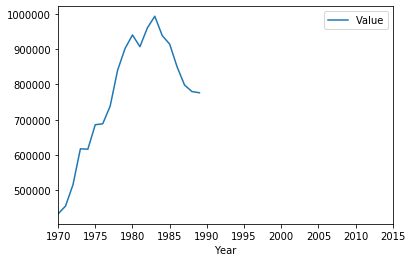

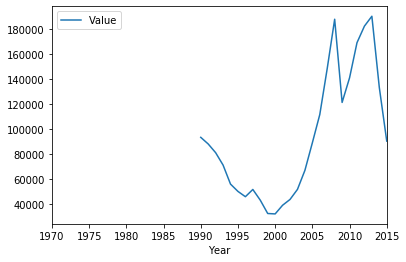

In [26]:
df_useful["GDP"][df_useful["GDP"]['Area']=='USSR'].plot(x ='Year', y='Value', kind = 'line')
df_useful["GDP"][df_useful["GDP"]['Area']=='Ukraine'].plot(x ='Year', y='Value', kind = 'line')

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 


In [27]:
countries_formation_years = {}
for country in df_useful["GDP"]["Area"].unique():
    selection = df_useful["GDP"]["Area"] == country
    year_in, year_out = df_useful["GDP"][selection].dropna()["Year"].min(), df_useful["GDP"][selection].dropna()["Year"].max()
    for year in (year_in, year_out):
        if year not in countries_formation_years :
            countries_formation_years[year] = []
    countries_formation_years[year_in].append((country,'+'))
    countries_formation_years[year_out].append((country,'-'))

countries_formation_years.pop(1970)
countries_formation_years.pop(2015)
print (countries_formation_years)

{1990: [('Armenia', '+'), ('Azerbaijan', '+'), ('Belarus', '+'), ('Bosnia and Herzegovina', '+'), ('Croatia', '+'), ('Czechia', '+'), ('Eritrea', '+'), ('Estonia', '+'), ('Ethiopia', '+'), ('Georgia', '+'), ('Kazakhstan', '+'), ('Kyrgyzstan', '+'), ('Latvia', '+'), ('Lithuania', '+'), ('Montenegro', '+'), ('Republic of Moldova', '+'), ('Russian Federation', '+'), ('Serbia', '+'), ('Slovakia', '+'), ('Slovenia', '+'), ('Tajikistan', '+'), ('The former Yugoslav Republic of Macedonia', '+'), ('Timor-Leste', '+'), ('Turkmenistan', '+'), ('Ukraine', '+'), ('Uzbekistan', '+')], 2005: [('Curaçao', '+'), ('Sint Maarten (Dutch Part)', '+')], 1989: [('Czechoslovakia', '-'), ('Ethiopia PDR', '-'), ('USSR', '-'), ('Yemen', '+'), ('Yugoslav SFR', '-')], 1999: [('Kosovo', '+')], 2012: [('Netherlands Antilles (former)', '-')], 2008: [('South Sudan', '+'), ('Sudan', '+')], 2007: [('Sudan (former)', '-')], 1988: [('Yemen Ar Rp', '-'), ('Yemen Dem', '-')]}


### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>

In [28]:
dic = {'Czechia': "Czech Republic",
       'Russian Federation':'Russia',
       "Serbia":"Republic of Serbia",
       'The former Yugoslav Republic of Macedonia':'Macedonia',
       'China, mainland':'China',
       'Viet Nam':'Vietnam',
       'Venezuela (Bolivarian Republic of)':'Venezuela',
       'Iran (Islamic Republic of)':'Iran',
       'Syrian Arab Republic':"Syria",
       'Bolivia (Plurinational State of)': 'Bolivia',
       "Côte d'Ivoire": "Ivory Coast",
       'Congo':"Republic of the Congo",
       "Lao People's Democratic Republic":'Laos',
       "Democratic People's Republic of Korea":"North Korea",
       'Republic of Korea':"South Korea"}

def correct_country_names(old_name):
    if old_name in dic.keys() :
        return dic[old_name]
    return old_name


In [29]:
for df_name in df_useful :
    print (df_name)
    df_useful[df_name]["Area"] = df_useful[df_name]["Area"].apply(correct_country_names)

GDP
Crops Area harvested
Crops Production
Crops Seed
Crops Yield
Livestock production
Live animals import quantities
Live animals export quantities
Crops import quantities
Crops export quantities
Consumer price indices


In [30]:
def visualise_world_data_folium(df, year, logScale=True, title=""):
    dic = {'USSR':                            ['Armenia', 'Azerbaijan','Belarus', 'Estonia', 'Georgia',
                                               'Kazakhstan', 'Kyrgyzstan', 'Latvia', 'Lithuania',
                                               'Montenegro', 'Republic of Moldova', 'Russia',
                                               'Republic of Serbia', 'Timor-Leste', 'Turkmenistan', 'Ukraine',
                                               'Uzbekistan'],
           'Ethiopia PDR':                     ['Eritrea','Ethiopia'],
           'Yugoslav SFR':                     ['Kosovo', 'Slovenia', 'Croatia',
                                                'Macedonia', 'Bosnia and Herzegovina'],
           'Yemen Dem' :                       ['Yemen'],        
           'Czechoslovakia':                   ["Czech Republic", 'Slovakia'],
           'Netherlands Antilles (former)':    ['Curaçao', 'Sint Maarten (Dutch Part)'],
           'Sudan (former)':                   ['South Sudan', 'Sudan']
          }
    def add_new_names(old_name):
        if old_name in dic.keys() :
            return dic[old_name]
        return old_name
    to_plot=df[df["Year"]==year]
    to_plot=(to_plot[['Area','Value']]
             .dropna()
             .groupby('Area')             
             .sum()
             .reset_index()
             .dropna())    
    to_plot['Area']=to_plot['Area'].apply(add_new_names)
    to_plot = to_plot.explode('Area')
    if logScale :
        to_plot.Value=np.log10(to_plot.Value)
    
    m = folium.Map(titles=title,location=[40,-10],zoom_start=1.6)
    folium.Choropleth(
        geo_data=f"https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json",
        data=to_plot,
        columns=['Area', 'Value'],
        key_on='feature.properties.name',
        fill_color='YlGn',fill_opacity=0.7,line_opacity=0.2,nan_fill_opacity=0.0
    ).add_to(m)

    folium.LayerControl().add_to(m)

    display(m)

In [31]:
visualise_world_data_folium(df_useful["GDP"], 1985, True, 'GDP for year 1985')

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

TODO, explain why (heavy tail, right skewed, power laws) + do it

For instance the distribution of GDP look a bit like a power law.

C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Martin\.conda\envs\ada\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


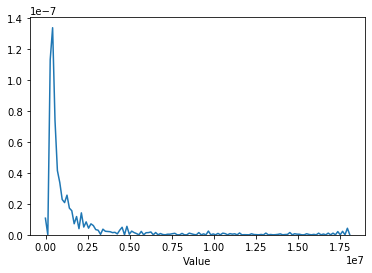

In [32]:
sns.distplot(df_useful["GDP"]["Value"], rug=False, hist=False)

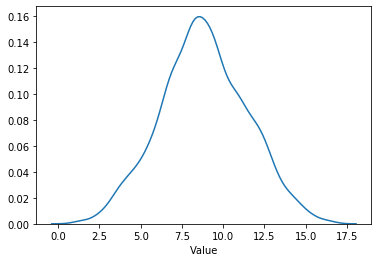

In [33]:
#looks better with log scale
sns.distplot(np.log(df_useful["GDP"]["Value"]), rug=False, hist=False)

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.


    Country | Year | GDP | Crops production columns | Livestock production columns | Crops importation columns | Livestock importation columns | Crops exportation columns | Livestock exportation | CPI
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


#### 1.F.a. Pivoting dataframes with items  <a name="1Fa"></a>

In [34]:
need_pivot = ['Crops Area harvested',
              'Crops Production',
              'Crops Seed',
              'Crops Yield',
              'Livestock production',
              'Live animals import quantities',
              'Live animals export quantities',
              'Crops import quantities',
              'Crops export quantities']

def rename_columns(x, word):
    if x not in ['Area', 'Year', 'ha', 'tonnes', 'hg/ha', 'Head', '1000 Head']:
        return x + ' ' + word
    return x

df_useful['GDP'] = df_useful['GDP'].rename(columns = {'Value':'(GDP, million $)'})[["Area",'Year','(GDP, million $)']]
df_useful['Consumer price indices'] = df_useful['Consumer price indices'].rename(columns = {'Value':'(Consumer price indices, %)'})[["Area",'Year','(Consumer price indices, %)']]

for df_name in need_pivot :
    df_useful[df_name] = pd.pivot_table(df_useful[df_name], index=["Area",'Year'], columns=["Item","Unit"], values="Value").rename(columns=lambda x: rename_columns(x, df_name))
    display(df_useful[df_name].sample(5))

,Item,"Anise, badian, fennel, coriander Crops Area harvested",Apples Crops Area harvested,Apricots Crops Area harvested,Areca nuts Crops Area harvested,Artichokes Crops Area harvested,Asparagus Crops Area harvested,Avocados Crops Area harvested,Bambara beans Crops Area harvested,Bananas Crops Area harvested,Barley Crops Area harvested,...,Sweet potatoes Crops Area harvested,"Tangerines, mandarins, clementines, satsumas Crops Area harvested",Taro (cocoyam) Crops Area harvested,Tomatoes Crops Area harvested,Tung nuts Crops Area harvested,"Vegetables&Melons, Total Crops Area harvested",Vetches Crops Area harvested,Watermelons Crops Area harvested,Wheat Crops Area harvested,Yams Crops Area harvested
,Unit,ha,ha,ha,ha,ha,ha,ha,ha,ha,ha,...,ha,ha,ha,ha,ha,ha,ha,ha,ha,ha
Area,Year,,,,,,,,,,,,,,,,,,,,,
Turkey,1970,4000.0,63537.0,40415.0,NaN,500.0,10.0,NaN,NaN,1000.0,2575000.0,...,NaN,8127.0,200.0,75000.0,NaN,626260.0,178900.0,124000.0,8615500.0,NaN
Hungary,2001,2799.0,57200.0,3750.0,NaN,NaN,700.0,NaN,NaN,NaN,367467.0,...,NaN,NaN,NaN,6316.0,NaN,102133.0,NaN,8290.0,1205610.0,NaN
Lebanon,1980,NaN,11000.0,3000.0,NaN,50.0,NaN,NaN,NaN,2000.0,8000.0,...,NaN,1400.0,50.0,5500.0,NaN,24830.0,3000.0,2000.0,15000.0,NaN
Niger,1974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1200.0,NaN,NaN,900.0,NaN,6381.0,NaN,NaN,1620.0,NaN
Afghanistan,1999,11288.0,3952.0,5303.0,NaN,NaN,NaN,NaN,NaN,NaN,180000.0,...,NaN,NaN,NaN,NaN,NaN,72033.0,NaN,12966.0,2027000.0,NaN


,Item,"Anise, badian, fennel, coriander Crops Production",Apples Crops Production,Apricots Crops Production,Areca nuts Crops Production,Artichokes Crops Production,Asparagus Crops Production,Avocados Crops Production,Bambara beans Crops Production,Bananas Crops Production,Barley Crops Production,...,Sweet potatoes Crops Production,"Tangerines, mandarins, clementines, satsumas Crops Production",Taro (cocoyam) Crops Production,Tomatoes Crops Production,Tung nuts Crops Production,"Vegetables&Melons, Total Crops Production",Vetches Crops Production,Watermelons Crops Production,Wheat Crops Production,Yams Crops Production
,Unit,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,...,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes
Area,Year,,,,,,,,,,,,,,,,,,,,,
Haiti,2005,NaN,NaN,NaN,NaN,NaN,NaN,54000.0,NaN,300000.0,NaN,...,200000.0,11000.0,NaN,2450.0,NaN,205858.0,NaN,NaN,NaN,220000.0
Bahamas,1990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5500.0,NaN,...,324.0,NaN,NaN,7500.0,NaN,26700.0,NaN,NaN,NaN,NaN
Switzerland,1975,NaN,435000.0,1000.0,NaN,NaN,NaN,NaN,NaN,NaN,172300.0,...,NaN,NaN,NaN,15500.0,NaN,257829.0,NaN,NaN,355500.0,NaN
Uruguay,2001,NaN,53809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117700.0,...,63000.0,97000.0,NaN,37000.0,NaN,167834.0,NaN,15500.0,143600.0,NaN
Sri Lanka,1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,133226.0,NaN,NaN,13061.0,NaN,276350.0,NaN,NaN,NaN,NaN


,Item,"Anise, badian, fennel, coriander Crops Seed",Bambara beans Crops Seed,Bananas Crops Seed,Barley Crops Seed,"Beans, dry Crops Seed","Broad beans, horse beans, dry Crops Seed",Buckwheat Crops Seed,Cabbages and other brassicas Crops Seed,Carrots and turnips Crops Seed,Cassava Crops Seed,...,Sorghum Crops Seed,Soybeans Crops Seed,Sugar cane Crops Seed,Sweet potatoes Crops Seed,Taro (cocoyam) Crops Seed,"Vegetables&Melons, Total Crops Seed",Vetches Crops Seed,Watermelons Crops Seed,Wheat Crops Seed,Yams Crops Seed
,Unit,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,...,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes
Area,Year,,,,,,,,,,,,,,,,,,,,,
Occupied Palestinian Territory,2005,4.0,NaN,NaN,1500.0,0.0,55.0,NaN,NaN,NaN,NaN,...,10.0,NaN,NaN,NaN,NaN,703.0,NaN,NaN,2744.0,NaN
Guyana,1994,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0
Suriname,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN
Iraq,1976,NaN,NaN,NaN,75500.0,300.0,728.0,NaN,NaN,NaN,NaN,...,439.0,78.0,NaN,NaN,NaN,NaN,48.0,NaN,89190.0,NaN
Argentina,2013,NaN,NaN,NaN,138932.0,10150.0,259.0,NaN,NaN,NaN,NaN,...,14961.0,1088000.0,NaN,NaN,NaN,NaN,NaN,NaN,365226.0,NaN


,Item,"Anise, badian, fennel, coriander Crops Yield",Apples Crops Yield,Apricots Crops Yield,Areca nuts Crops Yield,Artichokes Crops Yield,Asparagus Crops Yield,Avocados Crops Yield,Bambara beans Crops Yield,Bananas Crops Yield,Barley Crops Yield,...,Sweet potatoes Crops Yield,"Tangerines, mandarins, clementines, satsumas Crops Yield",Taro (cocoyam) Crops Yield,Tomatoes Crops Yield,Tung nuts Crops Yield,"Vegetables&Melons, Total Crops Yield",Vetches Crops Yield,Watermelons Crops Yield,Wheat Crops Yield,Yams Crops Yield
,Unit,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,...,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha,hg/ha
Area,Year,,,,,,,,,,,,,,,,,,,,,
Sao Tome and Principe,1987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50235.0,NaN,...,NaN,NaN,51000.0,NaN,NaN,53061.0,NaN,NaN,NaN,53200.0
Timor-Leste,1968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300000.0,NaN,...,39616.0,NaN,NaN,NaN,NaN,23471.0,NaN,NaN,NaN,NaN
Romania,1985,NaN,84229.0,53125.0,NaN,NaN,NaN,NaN,NaN,NaN,25913.0,...,NaN,NaN,NaN,272682.0,NaN,144487.0,NaN,NaN,23381.0,NaN
Cyprus,1995,NaN,93000.0,78125.0,NaN,169697.0,NaN,109091.0,NaN,403846.0,23509.0,...,NaN,105556.0,278261.0,690909.0,NaN,343087.0,13760.0,480000.0,30137.0,NaN
Ethiopia PDR,1986,6429.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,150000.0,9862.0,...,80000.0,48485.0,NaN,121053.0,NaN,32569.0,6375.0,NaN,9960.0,40984.0


,Item,Animals live nes Livestock production,Asses Livestock production,Beehives Livestock production,Buffaloes Livestock production,"Camelids, other Livestock production",Camels Livestock production,Cattle Livestock production,Cattle and Buffaloes Livestock production,Chickens Livestock production,Ducks Livestock production,...,Horses Livestock production,Mules Livestock production,"Pigeons, other birds Livestock production",Pigs Livestock production,Poultry Birds Livestock production,Rabbits and hares Livestock production,"Rodents, other Livestock production",Sheep Livestock production,Sheep and Goats Livestock production,Turkeys Livestock production
,Unit,Head,Head,No Livestock production,Head,Head,Head,Head,Head,1000 Head,1000 Head,...,Head,Head,1000 Head,Head,1000 Head,1000 Head,1000 Head,Head,Head,1000 Head
Area,Year,,,,,,,,,,,,,,,,,,,,,
Réunion,2006,NaN,10.0,NaN,NaN,NaN,NaN,36372.0,36372.0,14000.0,520.0,...,430.0,5.0,NaN,73312.0,14771.0,200.0,NaN,1024.0,37104.0,240.0
Finland,1983,NaN,NaN,50000.0,NaN,NaN,NaN,1662100.0,1662100.0,8509.0,NaN,...,35500.0,NaN,NaN,1465900.0,8509.0,NaN,NaN,104000.0,106000.0,NaN
Saint Pierre and Miquelon,1980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
Ivory Coast,2014,NaN,NaN,NaN,NaN,NaN,NaN,1587000.0,1587000.0,62000.0,NaN,...,NaN,NaN,NaN,370000.0,62000.0,NaN,NaN,1740000.0,3140000.0,NaN
Poland,1989,NaN,NaN,1650000.0,NaN,NaN,NaN,10732577.0,10732577.0,59820.0,4812.0,...,972749.0,NaN,NaN,18834992.0,66188.0,1900.0,NaN,4409021.0,4409021.0,548.0


Item                     Animals live nes Live animals import quantities  \
Unit                                                                Head   
Area                Year                                                   
Trinidad and Tobago 1973                                             0.0   
Guinea-Bissau       1963                                             NaN   
Aruba               2012                                             0.0   
Jordan              1993                                             0.0   
Algeria             1994                                             0.0   

Item                     Asses Live animals import quantities  \
Unit                                                     Head   
Area                Year                                        
Trinidad and Tobago 1973                                  NaN   
Guinea-Bissau       1963                                  0.0   
Aruba               2012                                  NaN   
Jordan              1993                                  0.0   
Algeria             1994                                  0.0   

Item                     Beehives Live animals import quantities  \
Unit                           No Live animals import quantities   
Area                Year                                           
Trinidad and Tobago 1973                                     NaN   
Guinea-Bissau       1963                                     NaN   
Aruba               2012                                     0.0   
Jordan              1993                                     NaN   
Algeria             1994                                     NaN   

Item                     Bovine, Animals Live animals import quantities  \
Unit                                                               Head   
Area                Year                                                  
Trinidad and Tobago 1973                                          299.0   
Guinea-Bissau       1963                                          449.0   
Aruba               2012                                           16.0   
Jordan              1993                                        13602.0   
Algeria             1994                                        12510.0   

Item                     Buffaloes Live animals import quantities  \
Unit                                                         Head   
Area                Year                                            
Trinidad and Tobago 1973                                      NaN   
Guinea-Bissau       1963                                      NaN   
Aruba               2012                                      NaN   
Jordan              1993                                      NaN   
Algeria             1994                                      NaN   

Item                     Camelids, other Live animals import quantities  \
Unit                                                               Head   
Area                Year                                                  
Trinidad and Tobago 1973                                            NaN   
Guinea-Bissau       1963                                            NaN   
Aruba               2012                                            NaN   
Jordan              1993                                            NaN   
Algeria             1994                                            NaN   

Item                     Camels Live animals import quantities  \
Unit                                                      Head   
Area                Year                                         
Trinidad and Tobago 1973                                   NaN   
Guinea-Bissau       1963                                   NaN   
Aruba               2012                                   NaN   
Jordan              1993                                   0.0   
Algeria             1994                                   0.0   

Item                     Cattle Live anim

Item                      Animals live nes Live animals export quantities  \
Unit                                                                 Head   
Area                 Year                                                   
Suriname             1961                                             NaN   
China, Hong Kong SAR 1981                                             0.0   
Chile                1963                                             NaN   
Yugoslav SFR         1989                                             NaN   
Madagascar           2009                                             0.0   

Item                      Asses Live animals export quantities  \
Unit                                                      Head   
Area                 Year                                        
Suriname             1961                                  NaN   
China, Hong Kong SAR 1981                                  NaN   
Chile                1963                                  NaN   
Yugoslav SFR         1989                               6200.0   
Madagascar           2009                                  NaN   

Item                      Beehives Live animals export quantities  \
Unit                            No Live animals export quantities   
Area                 Year                                           
Suriname             1961                                     NaN   
China, Hong Kong SAR 1981                                     NaN   
Chile                1963                                     NaN   
Yugoslav SFR         1989                                     NaN   
Madagascar           2009                                     NaN   

Item                      Bovine, Animals Live animals export quantities  \
Unit                                                                Head   
Area                 Year                                                  
Suriname             1961                                            0.0   
China, Hong Kong SAR 1981                                           83.0   
Chile                1963                                            0.0   
Yugoslav SFR         1989                                       217178.0   
Madagascar           2009                                            0.0   

Item                      Buffaloes Live animals export quantities  \
Unit                                                          Head   
Area                 Year                                            
Suriname             1961                                      NaN   
China, Hong Kong SAR 1981                                      NaN   
Chile                1963                                      NaN   
Yugoslav SFR         1989                                      0.0   
Madagascar           2009                                      NaN   

Item                      Camelids, other Live animals export quantities  \
Unit                                                                Head   
Area                 Year                                                  
Suriname             1961                                            NaN   
China, Hong Kong SAR 1981                                            NaN   
Chile                1963                                            NaN   
Yugoslav SFR         1989                                            NaN   
Madagascar           2009                                            NaN   

Item                      Camels Live animals export quantities  \
Unit                                                       Head   
Area                 Year                                         
Suriname             1961                                   NaN   
China, Hong Kong SAR 1981                                   NaN   
Chile                1963                                   NaN   
Yugoslav SFR         1989                                   NaN   
Madagascar           2009                            

,Item,Alfalfa meal and pellets Crops import quantities,Almonds shelled Crops import quantities,Animal Oil+Fat+Grs Crops import quantities,Animal Vegetable Oil Crops import quantities,Animal fats Crops import quantities,"Anise, badian, fennel, coriander Crops import quantities",Apples Crops import quantities,Apricots Crops import quantities,"Apricots, dry Crops import quantities",Artichokes Crops import quantities,...,"Wheat+Flour,Wheat Equivalent Crops import quantities","Whey, Pres+Concen Crops import quantities","Whey, condensed Crops import quantities","Whey, dry Crops import quantities",Wine Crops import quantities,Wine+Vermouth+Sim. Crops import quantities,"Wool, degreased Crops import quantities","Wool, greasy Crops import quantities","Wool, hair waste Crops import quantities","Yoghurt, concentrated or not Crops import quantities"
,Unit,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,...,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes
Area,Year,,,,,,,,,,,,,,,,,,,,,
Pacific Islands Trust Territory,1986,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,...,2361.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN
Pakistan,1976,NaN,0.0,36412.0,279648.0,36412.0,1174.0,1318.0,2174.0,0.0,NaN,...,1186207.0,0.0,0.0,0.0,4.0,4.0,64.0,336.0,0.0,NaN
Kuwait,1961,NaN,NaN,0.0,2900.0,0.0,0.0,1000.0,0.0,NaN,NaN,...,64005.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0
Afghanistan,2009,NaN,NaN,0.0,199874.0,0.0,NaN,954.0,NaN,NaN,NaN,...,2068920.0,NaN,NaN,NaN,258.0,258.0,NaN,0.0,0.0,145.0
Faroe Islands,2004,395.0,24.0,3.0,304.0,3.0,0.0,513.0,1.0,4.0,0.0,...,9207.0,0.0,NaN,0.0,304.0,326.0,32.0,0.0,0.0,34.0


,Item,Alfalfa meal and pellets Crops export quantities,Almonds shelled Crops export quantities,Animal Oil+Fat+Grs Crops export quantities,Animal Vegetable Oil Crops export quantities,Animal fats Crops export quantities,"Anise, badian, fennel, coriander Crops export quantities",Apples Crops export quantities,Apricots Crops export quantities,"Apricots, dry Crops export quantities",Artichokes Crops export quantities,...,"Wheat+Flour,Wheat Equivalent Crops export quantities","Whey, Pres+Concen Crops export quantities","Whey, condensed Crops export quantities","Whey, dry Crops export quantities",Wine Crops export quantities,Wine+Vermouth+Sim. Crops export quantities,"Wool, degreased Crops export quantities","Wool, greasy Crops export quantities","Wool, hair waste Crops export quantities","Yoghurt, concentrated or not Crops export quantities"
,Unit,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,...,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes,tonnes
Area,Year,,,,,,,,,,,,,,,,,,,,,
Libya,2003,NaN,NaN,NaN,4.0,NaN,0.0,NaN,NaN,NaN,NaN,...,93.0,NaN,NaN,NaN,9.0,9.0,915.0,3219.0,NaN,NaN
Argentina,1991,341.0,0.0,22702.0,2787118.0,22702.0,525.0,215694.0,6.0,385.0,NaN,...,5783490.0,0.0,NaN,0.0,31460.0,34499.0,15376.0,23468.0,3512.0,0.0
Falkland Islands (Malvinas),1992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2772.0,NaN,NaN
Netherlands,2003,48945.0,4018.0,90266.0,2558373.0,90266.0,4710.0,349414.0,4306.0,1178.0,634.0,...,692781.0,147363.0,38796.0,108567.0,35044.0,36984.0,231.0,1536.0,101.0,9284.0
United Kingdom,2003,226.0,529.0,60668.0,524123.0,60668.0,547.0,18518.0,113.0,425.0,16.0,...,3817095.0,42647.0,11650.0,30997.0,21857.0,22036.0,29512.0,11079.0,6333.0,9751.0


In [35]:
# Deal with the NaN that appeared
for df_name in df_useful :
    for column in list(df_useful[df_name]):
        if column not in ['Area', 'Year']:
            df_useful[df_name][column].fillna(df_useful[df_name][column].median(), inplace=True)

#### 1.F.b. Merging everything  <a name="1Fb"></a>

In [36]:
uni_df = df_useful['GDP']
for df_name in need_pivot :
    uni_df = pd.merge(uni_df, df_useful[df_name], how='outer', on=['Area', 'Year'])
uni_df = pd.merge(uni_df,df_useful['Consumer price indices'], how='outer', on=['Area', 'Year'])

# Deal with the NaN that appeared
for column in list(uni_df):
    if column not in ['Area', 'Year']:
        uni_df[column].fillna(uni_df[column].median(), inplace=True)
uni_df.sample(30)

C:\Users\Martin\.conda\envs\ada\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Area,Year,"(GDP, million $)","(Anise, badian, fennel, coriander Crops Area harvested, ha)","(Apples Crops Area harvested, ha)","(Apricots Crops Area harvested, ha)","(Areca nuts Crops Area harvested, ha)","(Artichokes Crops Area harvested, ha)","(Asparagus Crops Area harvested, ha)","(Avocados Crops Area harvested, ha)",...,"(Whey, Pres+Concen Crops export quantities, tonnes)","(Whey, condensed Crops export quantities, tonnes)","(Whey, dry Crops export quantities, tonnes)","(Wine Crops export quantities, tonnes)","(Wine+Vermouth+Sim. Crops export quantities, tonnes)","(Wool, degreased Crops export quantities, tonnes)","(Wool, greasy Crops export quantities, tonnes)","(Wool, hair waste Crops export quantities, tonnes)","(Yoghurt, concentrated or not Crops export quantities, tonnes)","(Consumer price indices, %)"
2949,Equatorial Guinea,1970,20.972338,1650.0,10960.0,3000.0,20235.0,1800.0,1404.0,1250.0,...,5.0,0.0,8.0,44.0,46.0,83.5,142.0,38.0,0.0,97.895927
11770,Réunion,1990,6406.727020,1650.0,30.0,3000.0,20235.0,1800.0,1404.0,41.0,...,5.0,0.0,8.0,44.0,46.0,83.5,142.0,38.0,0.0,97.895927
2943,El Salvador,2010,21418.328456,1650.0,3500.0,3000.0,20235.0,1800.0,1404.0,440.0,...,60.0,0.0,60.0,1.0,1.0,0.0,0.0,38.0,747.0,102.201250
7216,South Korea,2005,898137.223950,1650.0,26907.0,3000.0,20235.0,1800.0,1404.0,1250.0,...,215.0,0.0,215.0,38.0,43.0,137.0,0.0,30.0,6488.0,78.013022
11616,Pacific Islands Trust Territory,1983,6406.727020,1650.0,10960.0,3000.0,20235.0,1800.0,1404.0,1250.0,...,5.0,0.0,8.0,44.0,46.0,83.5,142.0,38.0,0.0,97.895927
412,Armenia,2014,11609.513241,1650.0,9976.0,9027.0,20235.0,1800.0,1404.0,1250.0,...,5.0,0.0,8.0,44.0,46.0,83.5,142.0,38.0,0.0,121.309894
2376,Curaçao,1995,6406.727020,1650.0,10960.0,3000.0,20235.0,1800.0,1404.0,1250.0,...,5.0,0.0,8.0,44.0,46.0,83.5,142.0,38.0,0.0,97.895927
472,Australia,1982,191727.483580,1650.0,18200.0,2330.0,20235.0,1800.0,1078.0,1250.0,...,2748.0,0.0,2748.0,8389.0,8429.0,63624.0,497566.0,3823.0,0.0,97.895927
4792,Kyrgyzstan,1973,6406.727020,1650.0,10960.0,3000.0,20235.0,1800.0,1404.0,1250.0,...,5.0,0.0,8.0,44.0,46.0,83.5,142.0,38.0,0.0,97.895927
12034,Sweden,1961,6406.727020,1650.0,10960.0,3000.0,20235.0,1800.0,1404.0,1250.0,...,0.0,0.0,0.0,4.0,4.0,200.0,370.0,292.0,0.0,97.895927


### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)      
                
    3. [Structure of international trade](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Prices of food](#2B), then study the [structure of international trade](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)

##### 2.A.a Crops and livestock production and trade <a name="2Aa"></a>
TODO

##### 2.A.b Introducing the concept of food self-sufficiency <a name="2Ab"></a>
In this section we will present and compute the notion of food self-sufficiency.
###### 2.A.b.i Basic idea <a name="2Abi"></a>
One may wonder how to know whether a country produce all the food it needs or not. The notion of food-self-sufficency allows to answer to this question. More formally, it is a rate that decribes how much does a country can satisfy to meet its internal consumption needs by production. It describes the extent to which a country is able to feed its population through its domestic food production.  We are interested into this measure since we think it could be correlated with the economic conditions of this country.
###### 2.A.b.ii Formula and computation <a name="2Abii"></a>
In order to compute the food self-sufficiency, we will apply the following formula that gives us the food self-sudfficiency as a percentage :

$$\frac{Production \times 100}{Production + Imports – Exports}$$

In [52]:
all_columns = list(uni_df)
production_columns = []
import_columns = []
export_columns = []
for column in all_columns:
    if (type(column)==tuple) and column[1]=='tonnes':
        if 'export quantities' in column[0]:
            export_columns.append(column)
        elif 'import quantities' in column[0]:
            import_columns.append(column)
        elif 'Production' in column[0]:
            production_columns.append(column)
            
uni_df[('All productions','tonnes')] = 0
for column in production_columns :
    uni_df[('All productions','tonnes')] += uni_df[column]            
uni_df[('All imports','tonnes')] = 0
for column in import_columns :
    uni_df[('All imports','tonnes')] += uni_df[column]            
uni_df[('All exports','tonnes')] = 0
for column in export_columns :
    uni_df[('All exports','tonnes')] += uni_df[column]
            
uni_df[('food self-sufficiency','%')] = 100 * uni_df[('All productions','tonnes')] / (uni_df[('All productions','tonnes')]+uni_df[('All imports','tonnes')]+uni_df[('All exports','tonnes')])


In [77]:
display(uni_df[['Area','Year',('food self-sufficiency','%')]].sample(5))

,Area,Year,"(food self-sufficiency, %)"
12920,Grenada,2016,91.903985
4198,Iran,1977,76.127914
12097,Tokelau,1970,91.262671
11795,Saint Kitts and Nevis,1961,94.923193
2373,Curaçao,1992,91.903985


In [79]:
plot = uni_df[['Area','Year']]
plot["Value"] = uni_df[('food self-sufficiency','%')]
visualise_world_data_folium(plot, 1985, False, 'food self-sufficiency for year 1985')

C:\Users\Martin\.conda\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 2.B. Prices of food  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Prices](#2Ba) 
    
        2. [Stability of prices](#2Bb)      
        
TODO

#### 2.C. Structure of international trade  <a name="2C"></a>

2.  
                
    3. 
    
        1. [One word about historical context](#2Ca) 
    
        2. [Clusters, circularity and openness rates of international trade](#2Cb)   

TODO

#### 2.D. Economic classification of countries <a name="2D"></a>
TODO

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Giving countries an economic score based on their agricultural features](#3C)
        
        1. [Correlation between food trade feature and GDP](#3Ca)
        
        2. [Our own score](#3Cb)
        
        2. [Machine learning model](#3Cc)  

    3. [Food prices stability and agricultural features](#3C)  
    
TODO

### 4. Informed plan for next actions  <a name="4"></a>

TODO